## A sniplet generating data simulating a high throughput expression analysis experiment

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

In [2]:
dat = generate_expression_data(n_analytes=10000)
data_labels = dat[1][:]
data = dat[0][:-1]

In [3]:
import scipy.stats as scistat

pval_plur = []

# Generate p-values through t-test
for i in range(0, data.shape[0]):
    pval_plur.append(scistat.ttest_ind(data.iloc[i, :3], data.iloc[i, 3:])[1])

# Generate q-values

In [4]:
def qvals(pval_plur):

    """ Takes a list of p-values and generates q-values as an numpy.ndarray """
    
    # Number of p-values
    m = len(pval_plur)

    # Create an array with tuples of index and value from pval_plur
    pval_plur = [[x, y] for x, y in sorted(enumerate(pval_plur))]
    pval_plur = np.array(pval_plur)

    # Sort after p-values, smallest to largest
    pval_plur = pval_plur[np.argsort(pval_plur[:, 1])]

    # Set our lambda and t
    lambd = 0.5
    t = 0.05

    # Count how many p-values are greater than our lambda
    i = 0
    for j in range(0, len(pval_plur)):
        if pval_plur[j][1] > lambd:
            i += 1
        else:
            next
    lambda_count = i

    # Calculate our Pi_0 and Q_P_i(m)
    pi_zero = lambda_count/(m*(1-lambd))
    qpim = pi_zero*pval_plur[-1][1]

    #qpii = [[1000, qpim]]
    qpii = []

    # generate q-values iterating over the ordered p-value-indexes from pval_plur
    for i in reversed(range(1, len(pval_plur)+1)):
        if i == len(pval_plur):
            qval = min(((pi_zero*pval_plur[i-1][1]*m)/i), pi_zero*pval_plur[i-2][1])
        else:
            qval = min(((pi_zero*pval_plur[i-1][1]*m)/i), pi_zero*pval_plur[i][1])

        qpii.append([pval_plur[i-1][0], qval])

    qpii = np.array(qpii)
    #qvals = np.array(qpii[::-1])

    #return the q-values to the original order
    qvals = qpii[np.argsort(qpii[:,0])]

    return qvals
    


In [5]:
a = qvals(pval_plur)
a

array([[  0.00000000e+00,   5.20362417e-02],
       [  1.00000000e+00,   6.55542771e-06],
       [  2.00000000e+00,   1.55830661e-01],
       ..., 
       [  9.99700000e+03,   1.43235545e-01],
       [  9.99800000e+03,   1.27214846e-01],
       [  9.99900000e+03,   7.70623525e-01]])

### Make a dataframe of q-values and the null statistic

In [6]:
#put them together before cumsum

q = qvals(pval_plur)

df = pd.DataFrame({'q':q[:,1], 'labs':data_labels.iloc[:,1]})

df = df.sort_values(by='q')

null = np.cumsum(1-df.iloc[:,0])/range(1, len(df.iloc[:,0])+1)
df['null'] = null


del df['labs']

# df.loc[df.iloc[:,0]>2000].index
# df.loc[df['q']==2278].index

#### 5. Plot the (simulated) number of differential expression genes as a function of q-value threshold.

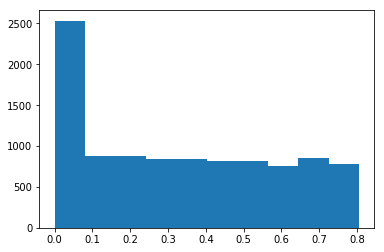

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(df.iloc[:,0]);

In [62]:
df;

###### 6. Plot the difference between q-values and the actual fraction of null statistics (using the labels from the generator).

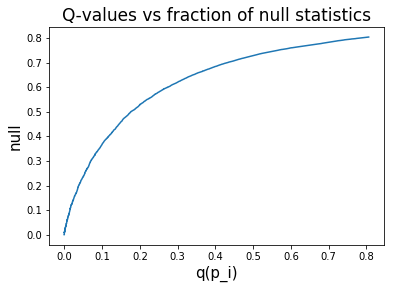

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import *

# True positives in data
(data_labels.iloc[:,1] == 1).describe()[3]

# plt.plot(q_of_pi_zero, cumsum(1-data_labels.iloc[:,1])/range(1, len(data_labels)+1))
plt.plot(df.iloc[:,0], df.iloc[:,1]);
plt.xlabel("q(p_i)", size=15)
plt.ylabel("null", size=15)
plt.title("Q-values vs fraction of null statistics", size=17);

In [9]:
import pandas as pd
df = pd.read_excel("MSB-12-901-s009.xlsx",skiprows=list(range(6))+list(range(15,18)),parse_cols=[0]+list(range(3,318)),header=0,index_col=0)


In [12]:
df

,_02_1,_02_2,_02_3,_02_4,_02_5,_02_6,_02_7,_03_1,_03_2,_03_3,...,_57_2,_57_3,_57_4,_57_5,_57_6,_57_7,_58_1,_58_2,_58_3,_58_4
Participant_Timepoint,,,,,,,,,,,,,,,,,,,,,
Weight,84.800000,71.500000,71.000000,70.000000,71.500000,73.200000,72.000000,97.650000,85.800000,82.600000,...,92.000000,92.000000,93.000000,92.400000,94.500000,96.800000,104.800000,94.100000,95.000000,96.000000
BMI,31.400000,26.200000,NaN,NaN,NaN,NaN,26.630000,36.000000,30.000000,NaN,...,28.000000,NaN,NaN,NaN,NaN,29.160000,31.800000,27.400000,NaN,NaN
Cholesterol,5.200000,4.300000,NaN,NaN,NaN,NaN,4.700000,4.700000,3.400000,NaN,...,4.000000,NaN,NaN,NaN,NaN,4.300000,4.000000,2.800000,NaN,NaN
LDL,3.200000,2.600000,NaN,NaN,NaN,NaN,2.900000,3.000000,2.000000,NaN,...,2.500000,NaN,NaN,NaN,NaN,2.400000,2.100000,1.200000,NaN,NaN
HDL,1.800000,1.300000,NaN,NaN,NaN,NaN,1.500000,1.200000,0.900000,NaN,...,0.900000,NaN,NaN,NaN,NaN,0.900000,1.500000,1.300000,NaN,NaN
Triglyceride,0.600000,0.800000,NaN,NaN,NaN,NaN,0.600000,1.200000,0.700000,NaN,...,1.500000,NaN,NaN,NaN,NaN,2.250000,0.800000,0.700000,NaN,NaN
HOMA-IR,1.478400,2.764178,NaN,NaN,NaN,NaN,1.600000,5.758644,4.599444,NaN,...,5.003333,NaN,NaN,NaN,NaN,11.948000,8.255556,4.586667,NaN,NaN
Leptin,17.000000,5.900000,17.000000,9.270000,13.400000,8.000000,8.750000,23.700000,6.690000,5.520000,...,3.740000,4.530000,9.000000,6.770000,6.010000,6.910000,33.000000,16.300000,28.900000,28.300000
A0A024R6I7;A0A0G2JRN3,9.384310,9.410237,9.408777,9.482436,9.483630,9.472084,9.370497,9.580927,9.670189,9.689987,...,8.955029,8.506492,8.485269,8.572326,8.459483,8.208898,9.607462,9.732481,9.760927,9.797781
